In [436]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from math import sqrt
import time
from collections import defaultdict

In [437]:
df = pd.read_csv('municipality_bus_utilization.csv')
df

timestamp  municipality_id  usage  total_capacity
0      2017-06-04 07:59:42                9    454            1332
1      2017-06-04 07:59:42                8    556            2947
2      2017-06-04 07:59:42                4   1090            3893
3      2017-06-04 07:59:42                0    204            2813
4      2017-06-04 07:59:42                7    718            2019
...                    ...              ...    ...             ...
13065  2017-08-19 16:30:35                2    548             697
13066  2017-08-19 16:30:35                8   1193            2947
13067  2017-08-19 16:30:35                7   1354            2019
13068  2017-08-19 16:30:35                6   1680            3113
13069  2017-08-19 16:30:35                3   1189            1930

[13070 rows x 4 columns]

# Exploratory Null Check

In [438]:
df.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [439]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
hour = df['hour'] = df['timestamp'].dt.hour
time = df['time'] = df['timestamp'].dt.date

# Split Dataset Into as Pre_Train and Pre_Test Sets

In [440]:
data = df.drop(['hour','time'], axis=1)

pre_traindata = data.iloc[:10390,:] # data.iloc[10390][0] = 2017-08-05 start point shown in problem book.
pre_testdata = data.iloc[10390:,:] # starting from 2017-08-05 to 2017-08-19 2 weeks.

pre_traindata = pre_traindata.sort_values(["municipality_id","timestamp"], ascending = (True,True))
pre_testdata = pre_testdata.sort_values(["municipality_id","timestamp"], ascending = (True,True))

pre_traindata_var_holder = {}
pre_testdata_var_holder = {}
for i in range(10):
    grouped = pre_traindata.groupby(pre_traindata.municipality_id)
    pre_traindata_var_holder['pre_traindata' + str(i)] = grouped.get_group(i)
    grouped = pre_testdata.groupby(pre_testdata.municipality_id)
    pre_testdata_var_holder['pre_testdata' + str(i)] = grouped.get_group(i)
locals().update(pre_traindata_var_holder) # after all of the "variables" created, update them to the locals "dictionary"(symbol table).
locals().update(pre_testdata_var_holder)

# Prepare Training Data Set

In [441]:
traindata_holder = {}
train_time_data_holder = {}

for i in range(10):
    traindata_holder['traindata' + str(i)] = pre_traindata_var_holder['pre_traindata' + str(i)].groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
    train_time_data_holder['train_time_data' + str(i)] = pre_traindata_var_holder['pre_traindata' + str(i)].groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
locals().update(traindata_holder)
locals().update(train_time_data_holder)

# Prepare Test Data Set

In [442]:
testdata_holder = {}
test_time_data_holder = {}
for i in range(10):
    testdata_holder['testdata' + str(i)] = pre_testdata_var_holder['pre_testdata' + str(i)].groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
    test_time_data_holder['test_time_data' + str(i)] = pre_testdata_var_holder['pre_testdata' + str(i)].groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
locals().update(testdata_holder)
locals().update(test_time_data_holder)

### Plot Train and Test Data

In [ ]:
for i in range(10):
    testdata_holder['testdata' + str(i)].index += len(traindata_holder['traindata' + str(i)])
    plt.figure(figsize=(20, 6), dpi=200)
    plt.plot(traindata_holder['traindata' + str(i)]["usage"].index, traindata_holder['traindata' + str(i)]["usage"], label='Train')
    plt.plot(testdata_holder['testdata' + str(i)]["usage"].index, testdata_holder['testdata' + str(i)]["usage"], 'r-', label = 'Test Data')
    plt.xlabel('Hours'); plt.ylabel('Bus'); plt.title('Forecast for Municipality %d' %i)
    plt.legend(loc="best")


 The dataset has stable trend and it hasn't been analyzed from special trend component point view. ( weekends, special days etc.)

# Predict Bus Usage with Holtwinters ExponentialSmoothing

In [444]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, HoltWintersResults


In [445]:
for i in range(10):
    traindata_holder['traindata' + str(i)].reset_index(inplace=True)
    traindata_holder['traindata' + str(i)].drop(['index'], axis=1, inplace=True)
    
    testdata_holder['testdata' + str(i)].reset_index(inplace=True)
    testdata_holder['testdata' + str(i)].drop(['index'], axis=1, inplace=True)

In [446]:
alpha = 0.1 #smoothing_level parameter

## Try ExponentialSmoothing with alpha=0.1 Optimized=False

In [ ]:
prediction_holder = {}
loss_holder = {}
for i in range(10):
    model = ExponentialSmoothing(traindata_holder['traindata' + str(i)]["usage"])
    model = ExponentialSmoothing.fit(model, smoothing_level=alpha, remove_bias=True, optimized=False)

    if i == 0:
        print(model.summary())
    prediction_holder['prediction' + str(i)] = HoltWintersResults.predict(model, start=testdata_holder['testdata' + str(i)]["usage"].index[0], end=testdata_holder['testdata' + str(i)]["usage"].index[-1])
    prediction_holder['prediction' + str(i)] = pd.Series(prediction_holder['prediction' + str(i)])
    prediction_holder['prediction' + str(i)].index += len(traindata_holder['traindata' + str(i)])
    testdata_holder['testdata' + str(i)].index += len(traindata_holder['traindata' + str(i)])
    plt.figure(figsize=(20, 6), dpi=200)
    plt.plot(traindata_holder['traindata' + str(i)]["usage"].index, traindata_holder['traindata' + str(i)]["usage"], label='Train Data')
    plt.plot(prediction_holder['prediction' + str(i)].index, prediction_holder['prediction' + str(i)], 'y-', label = 'Forecast')
    plt.plot(testdata_holder['testdata' + str(i)]["usage"].index, testdata_holder['testdata' + str(i)]["usage"], 'r-', label = 'Test Data')
    plt.xlabel('Hours'); plt.ylabel('Bus Usage'); plt.title('Forecast for Municipality %d' %i)
    plt.legend(loc="best")


As seem from the graphs, prediction and test data has big gap and it needs hyperparameter smoothing_level to be optimized.

## Try ExponentialSmoothing with alpha=autosetting, Optimized=True

As a result of model.fit with training data & optimization switch is ON, alpha is calculated as 0.995 by municipality model.(model0)

In [448]:
for i in range(10):
    traindata_holder['traindata' + str(i)].reset_index(inplace=True)
    traindata_holder['traindata' + str(i)].drop(['index'], axis=1, inplace=True)
    
    testdata_holder['testdata' + str(i)].reset_index(inplace=True)
    testdata_holder['testdata' + str(i)].drop(['index'], axis=1, inplace=True)

reset dataset indexes to retrieve the correct data.

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    usage   No. Observations:                  532
Model:             ExponentialSmoothing   SSE                       14506696.400
Optimized:                         True   AIC                           5437.570
Trend:                             None   BIC                           5446.123
Seasonal:                          None   AICC                          5437.646
Seasonal Periods:                  None   Date:                 Tue, 11 Oct 2022
Box-Cox:                          False   Time:                         15:54:23
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
initial_level              359.127

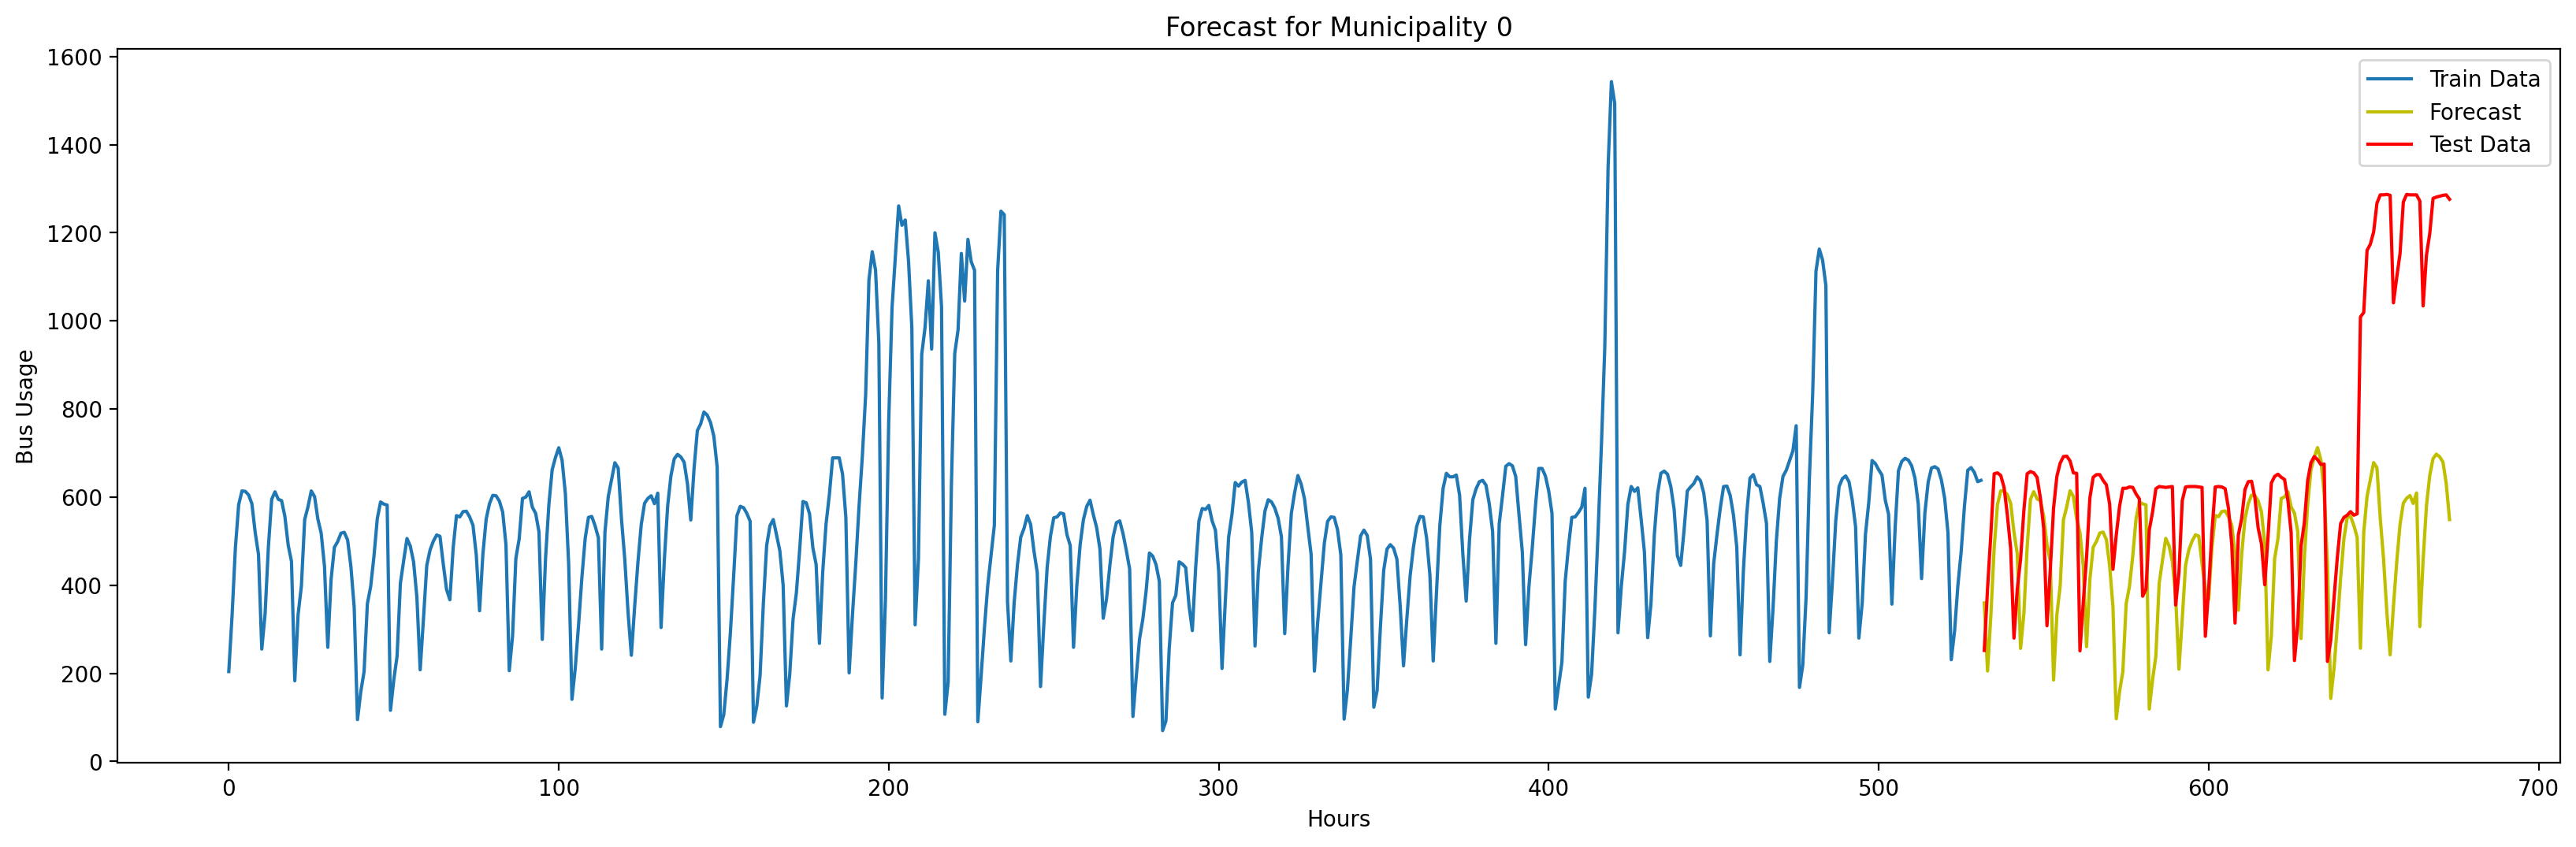

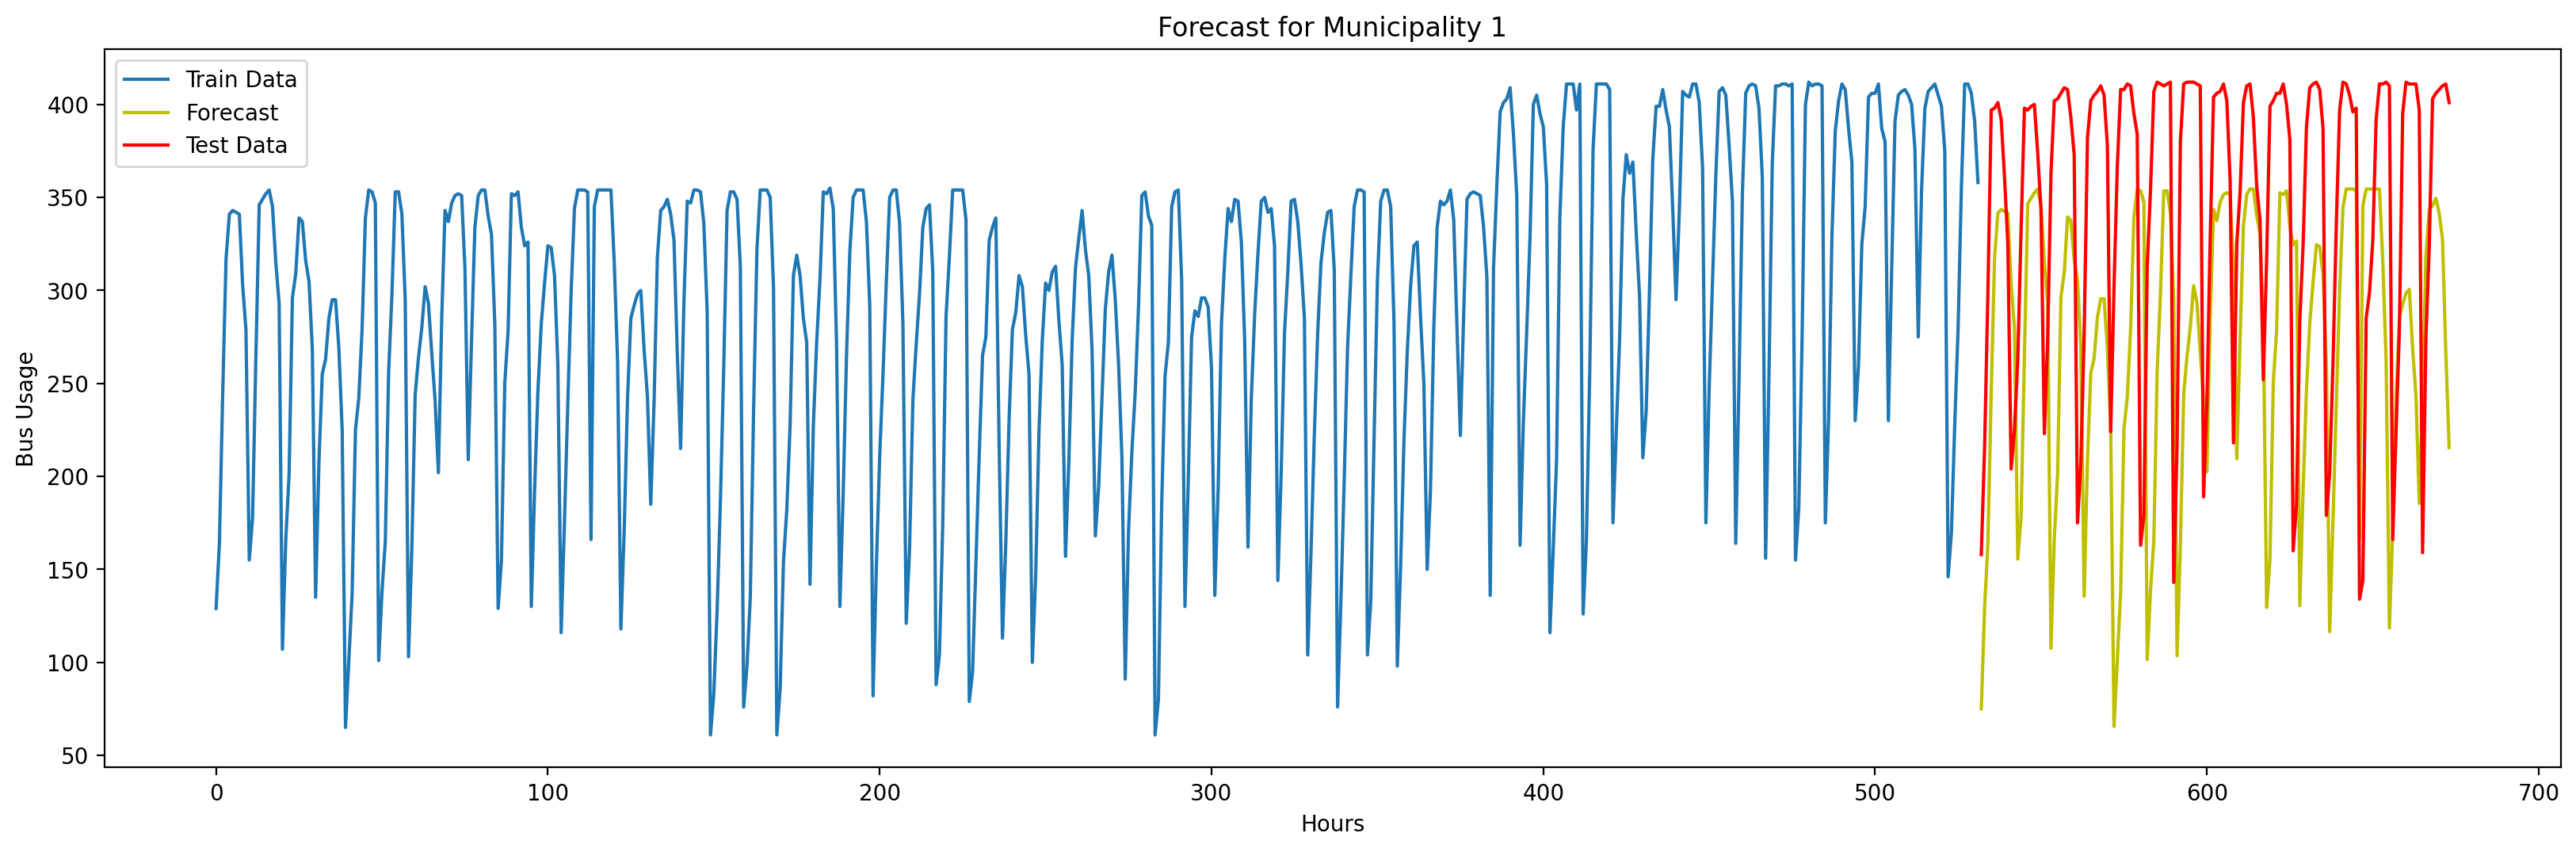

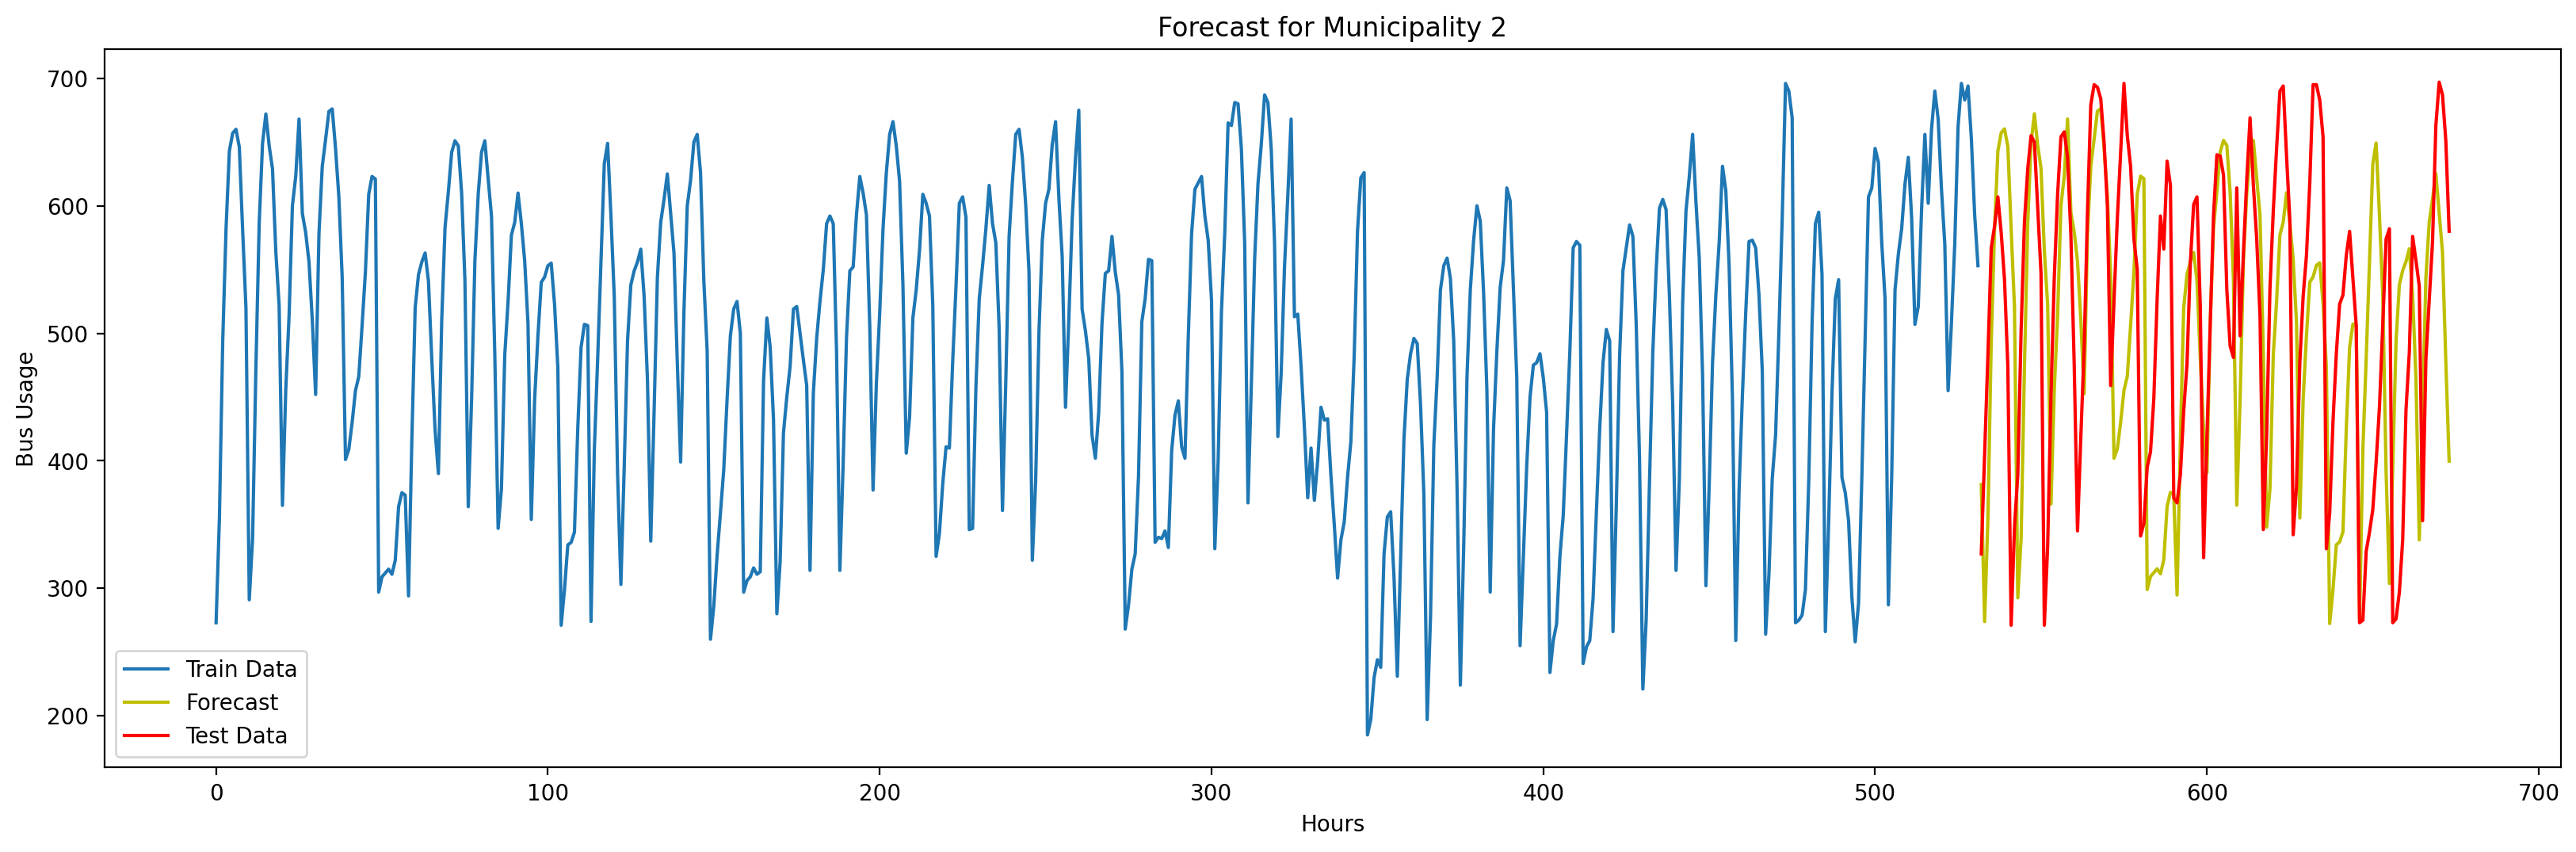

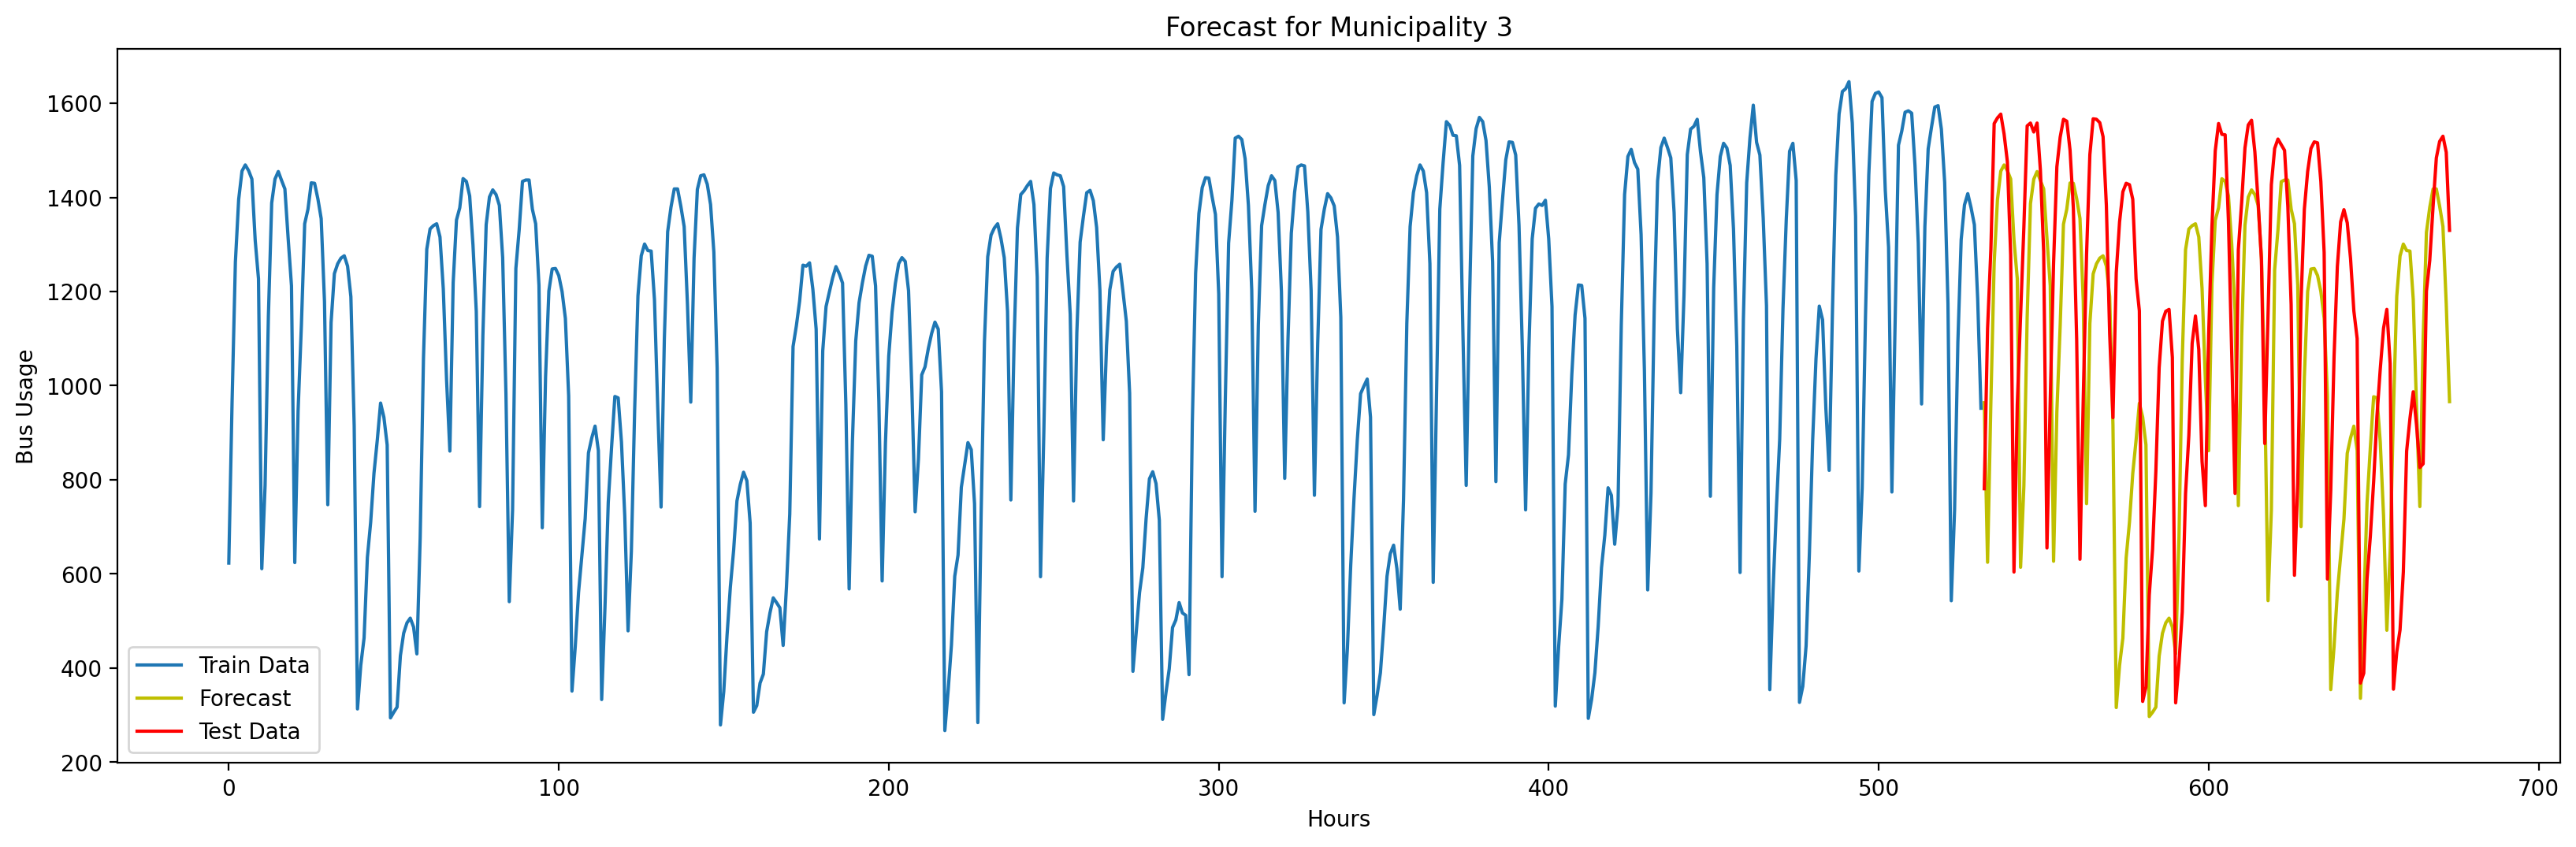

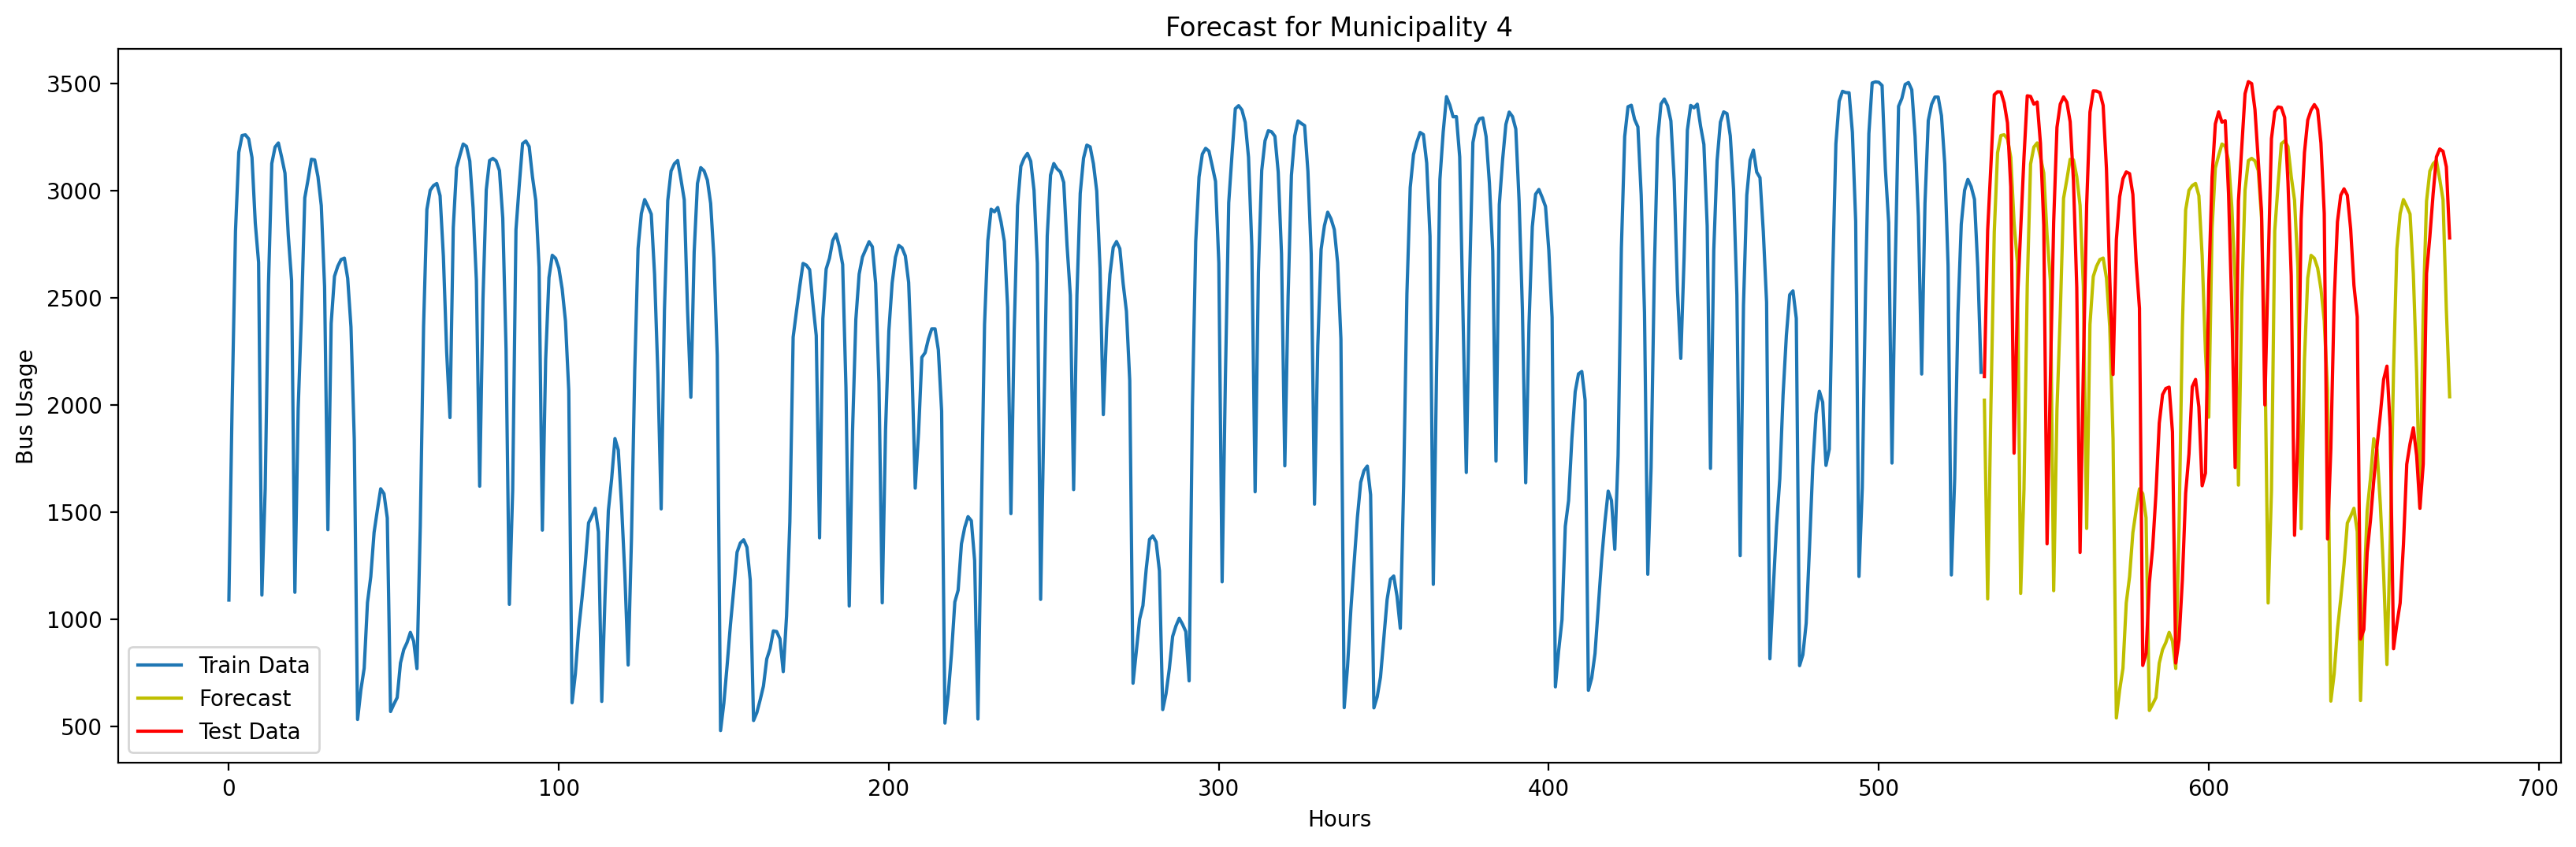

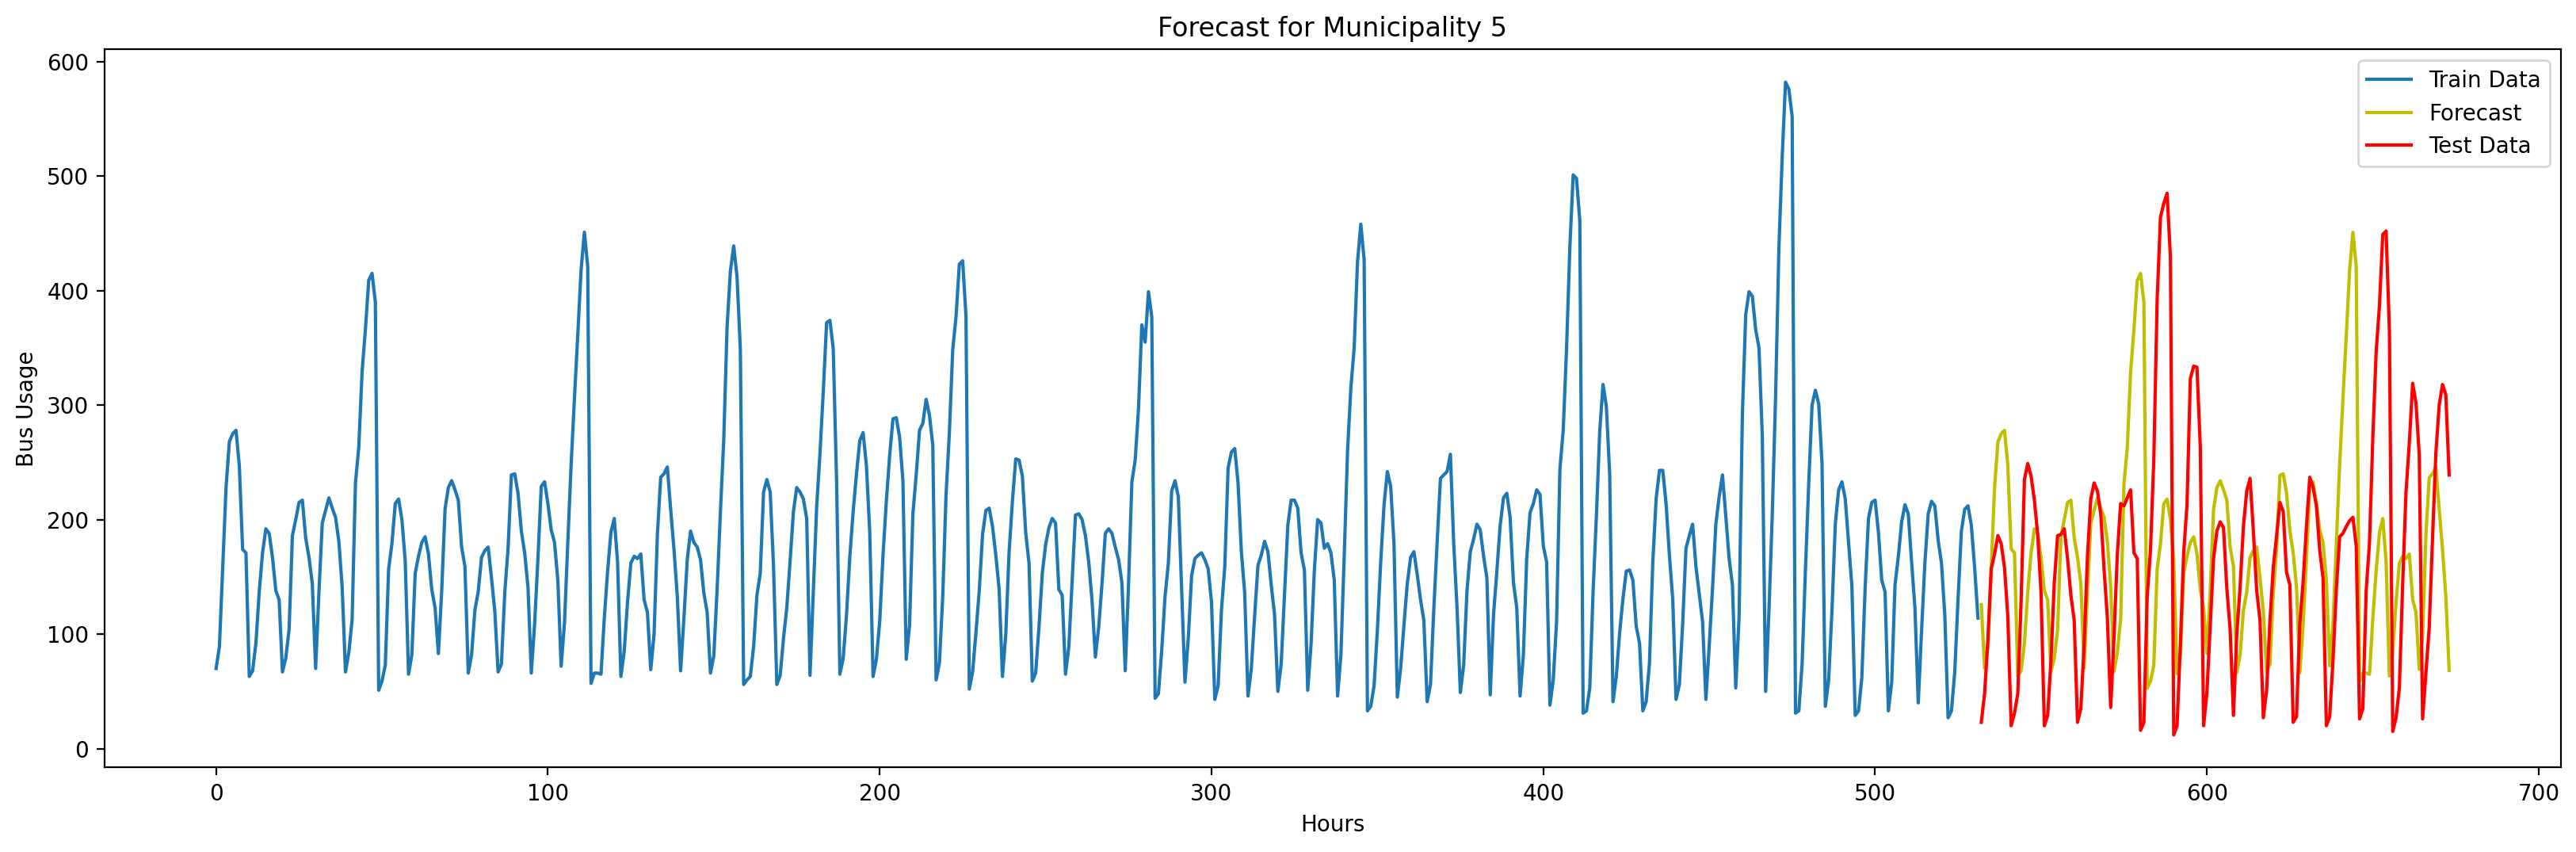

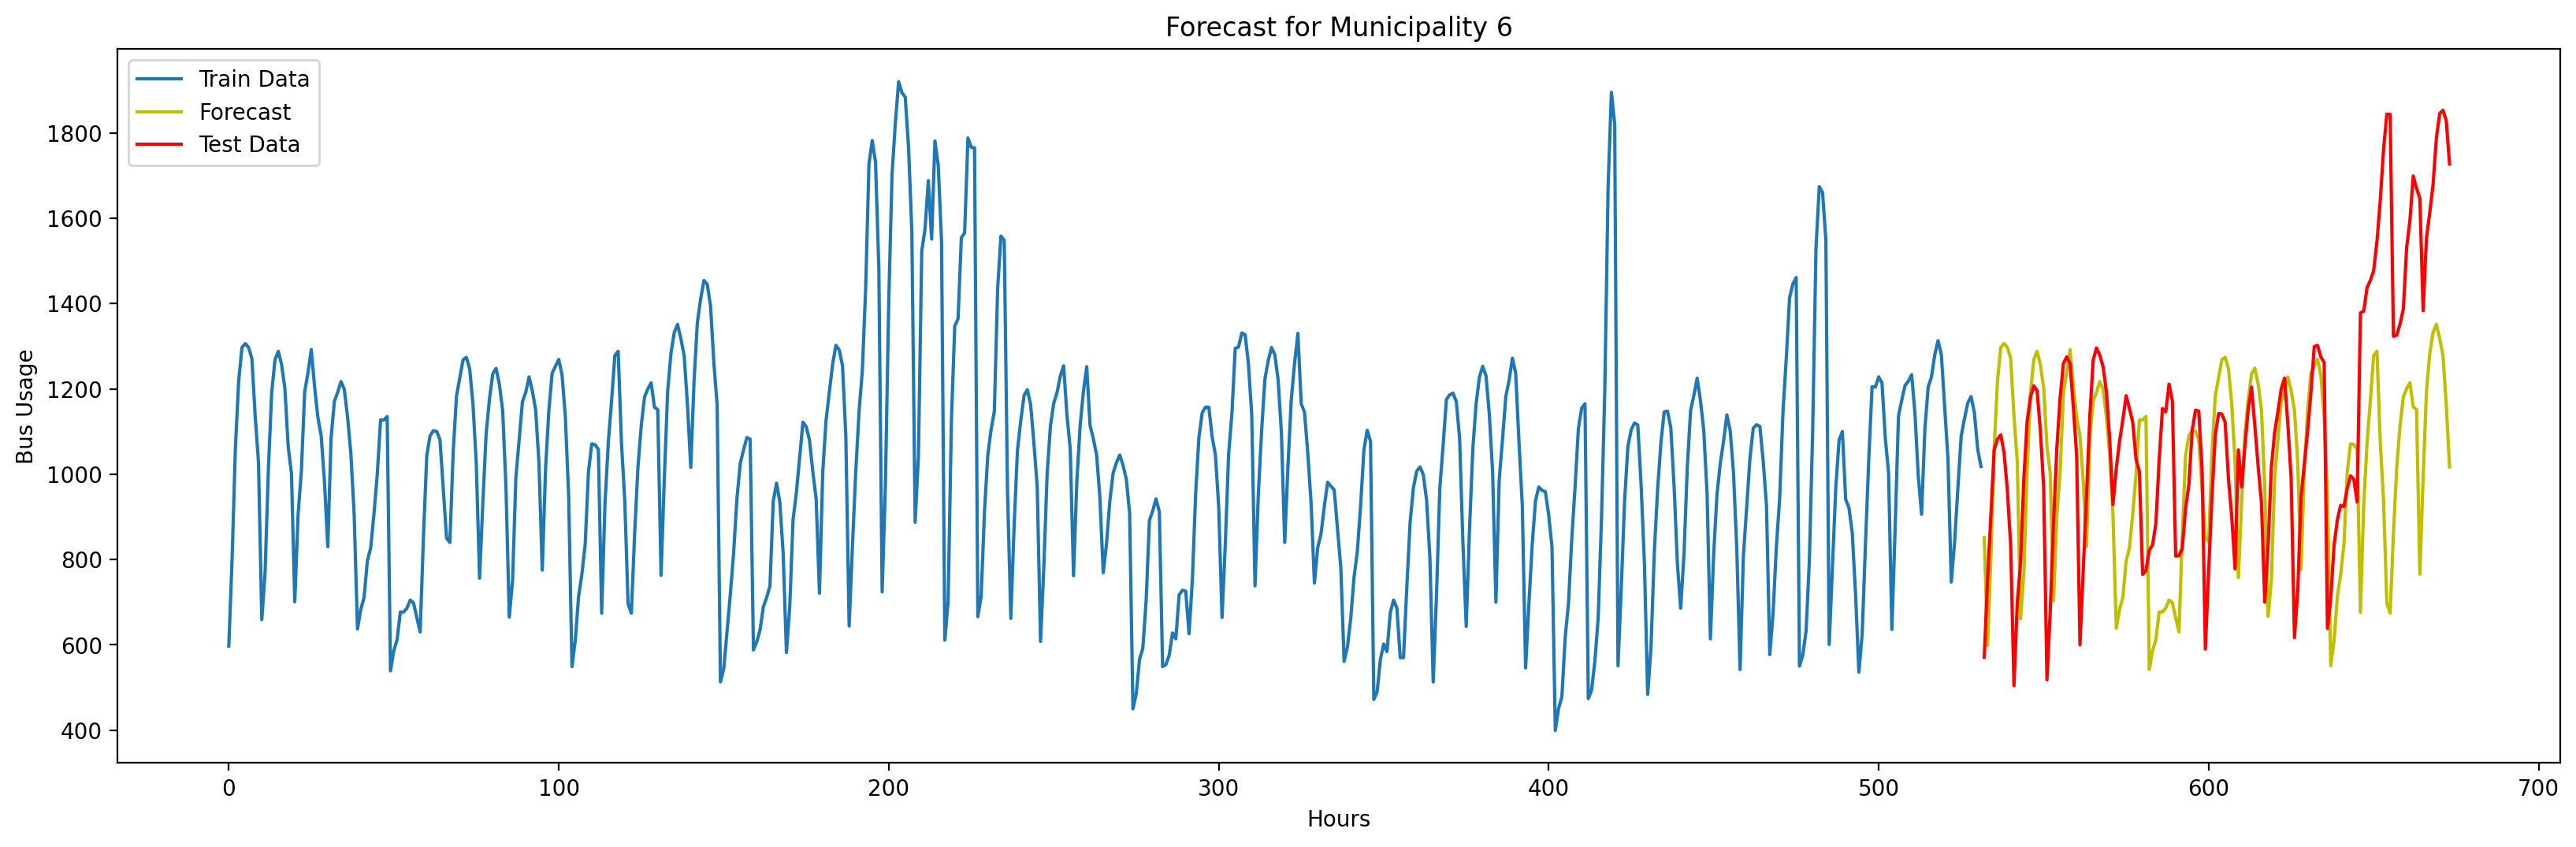

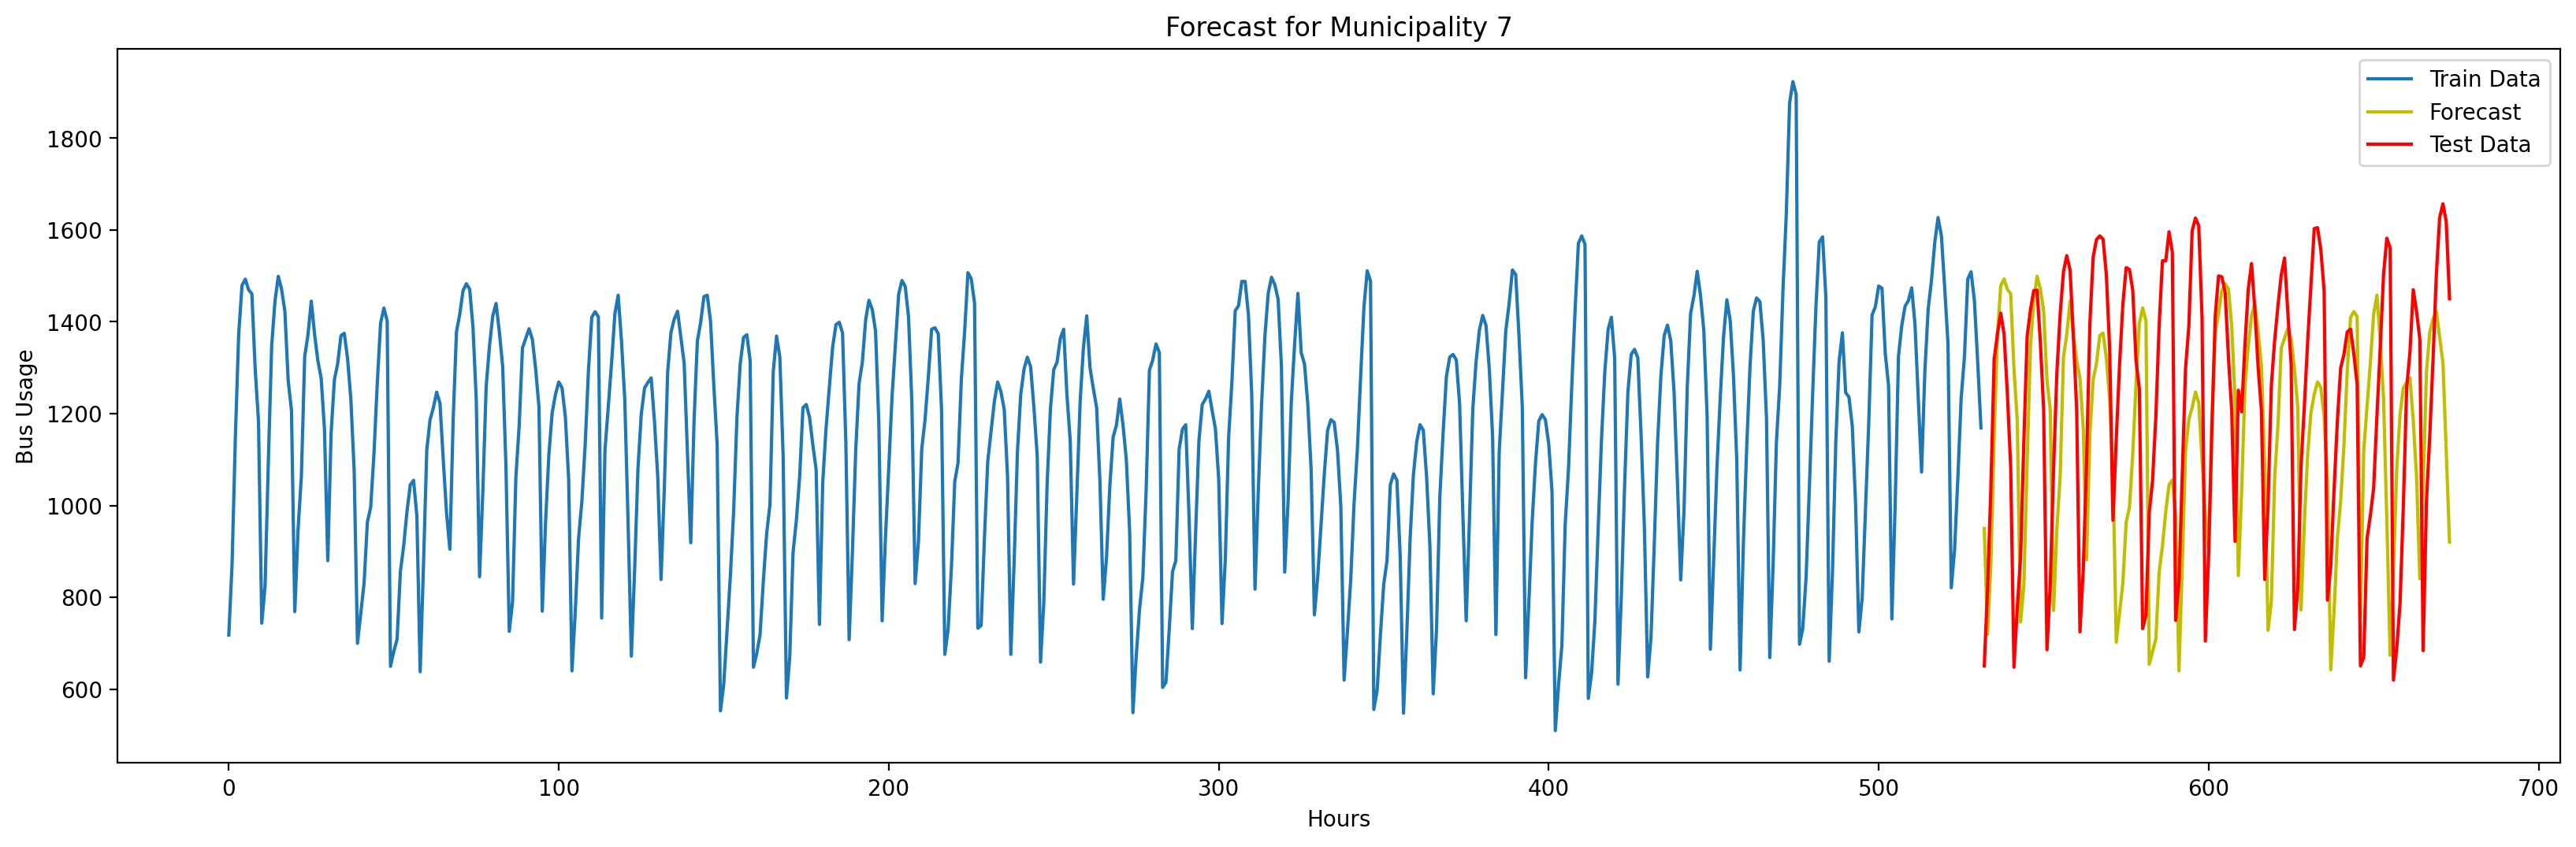

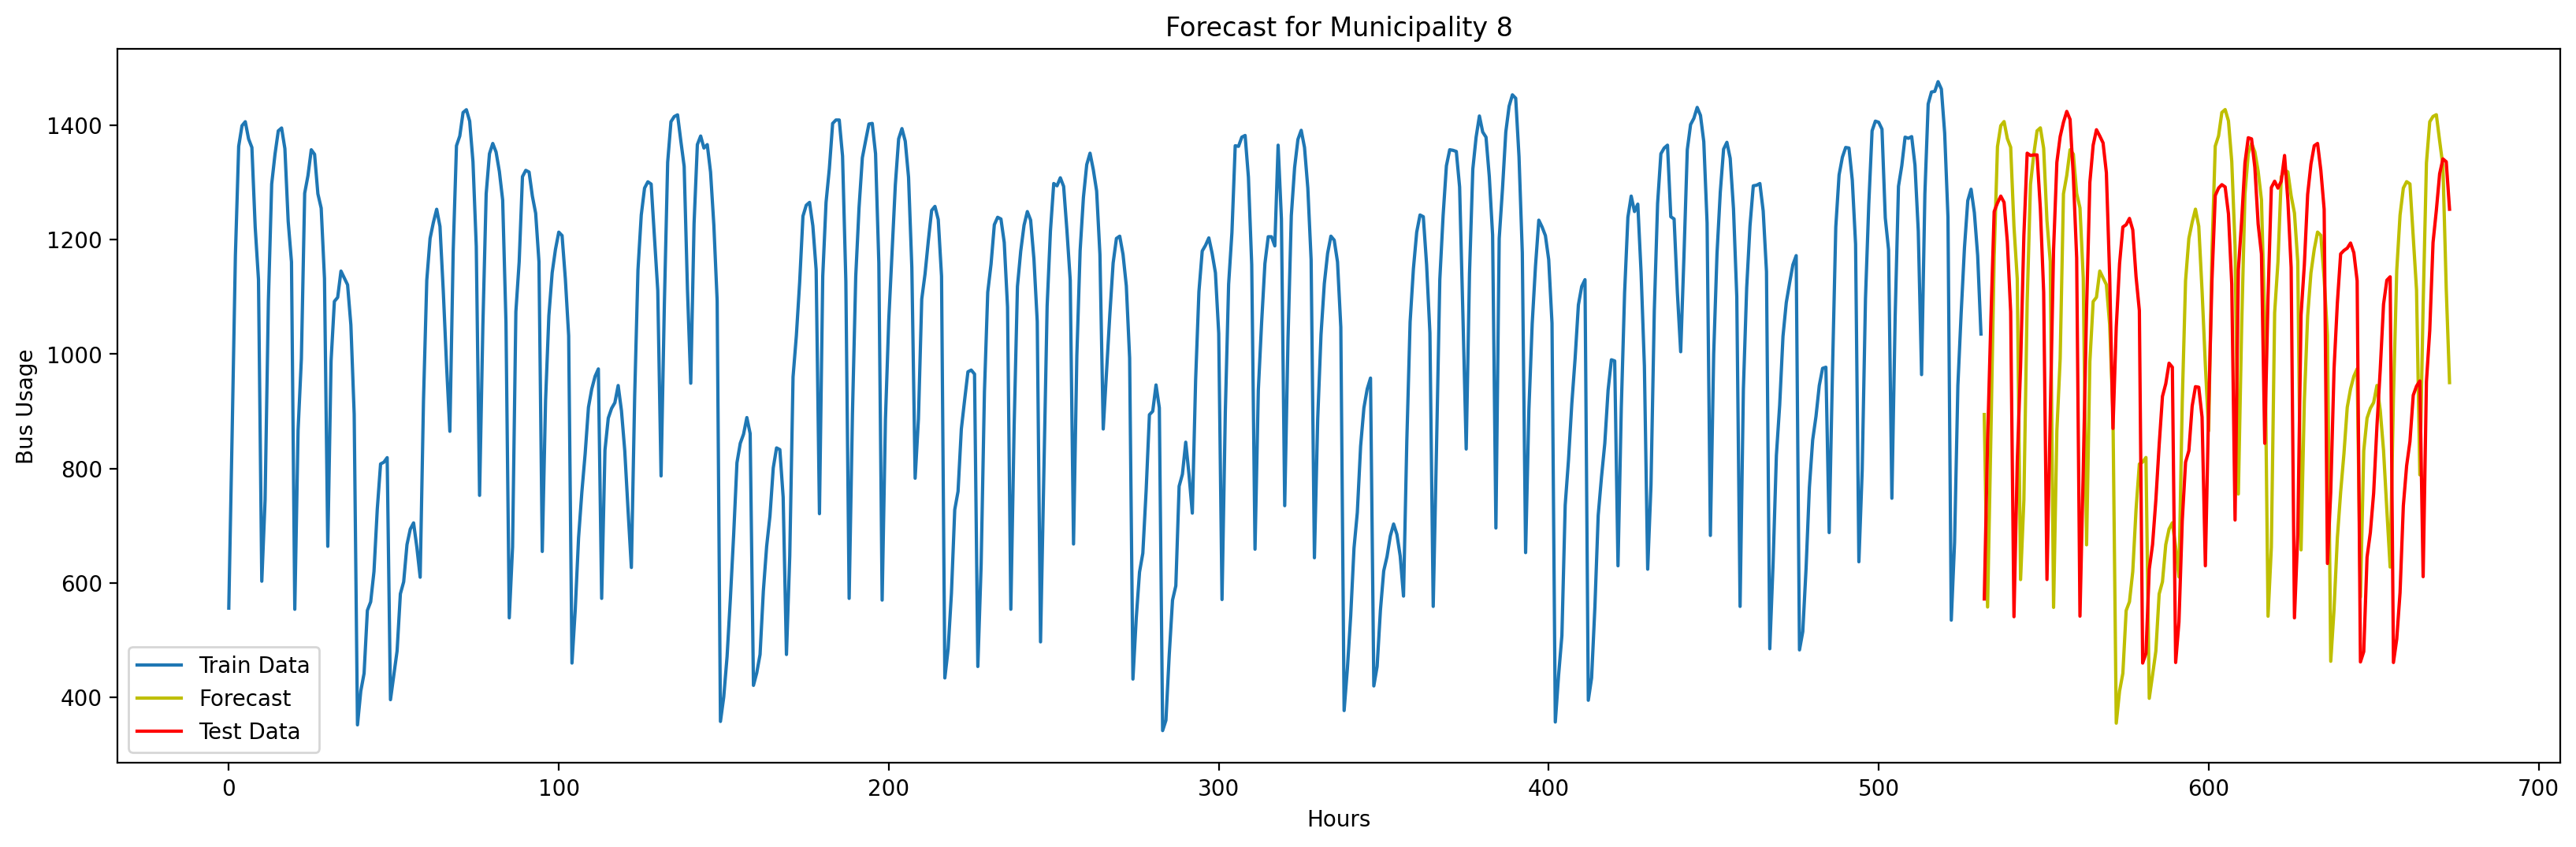

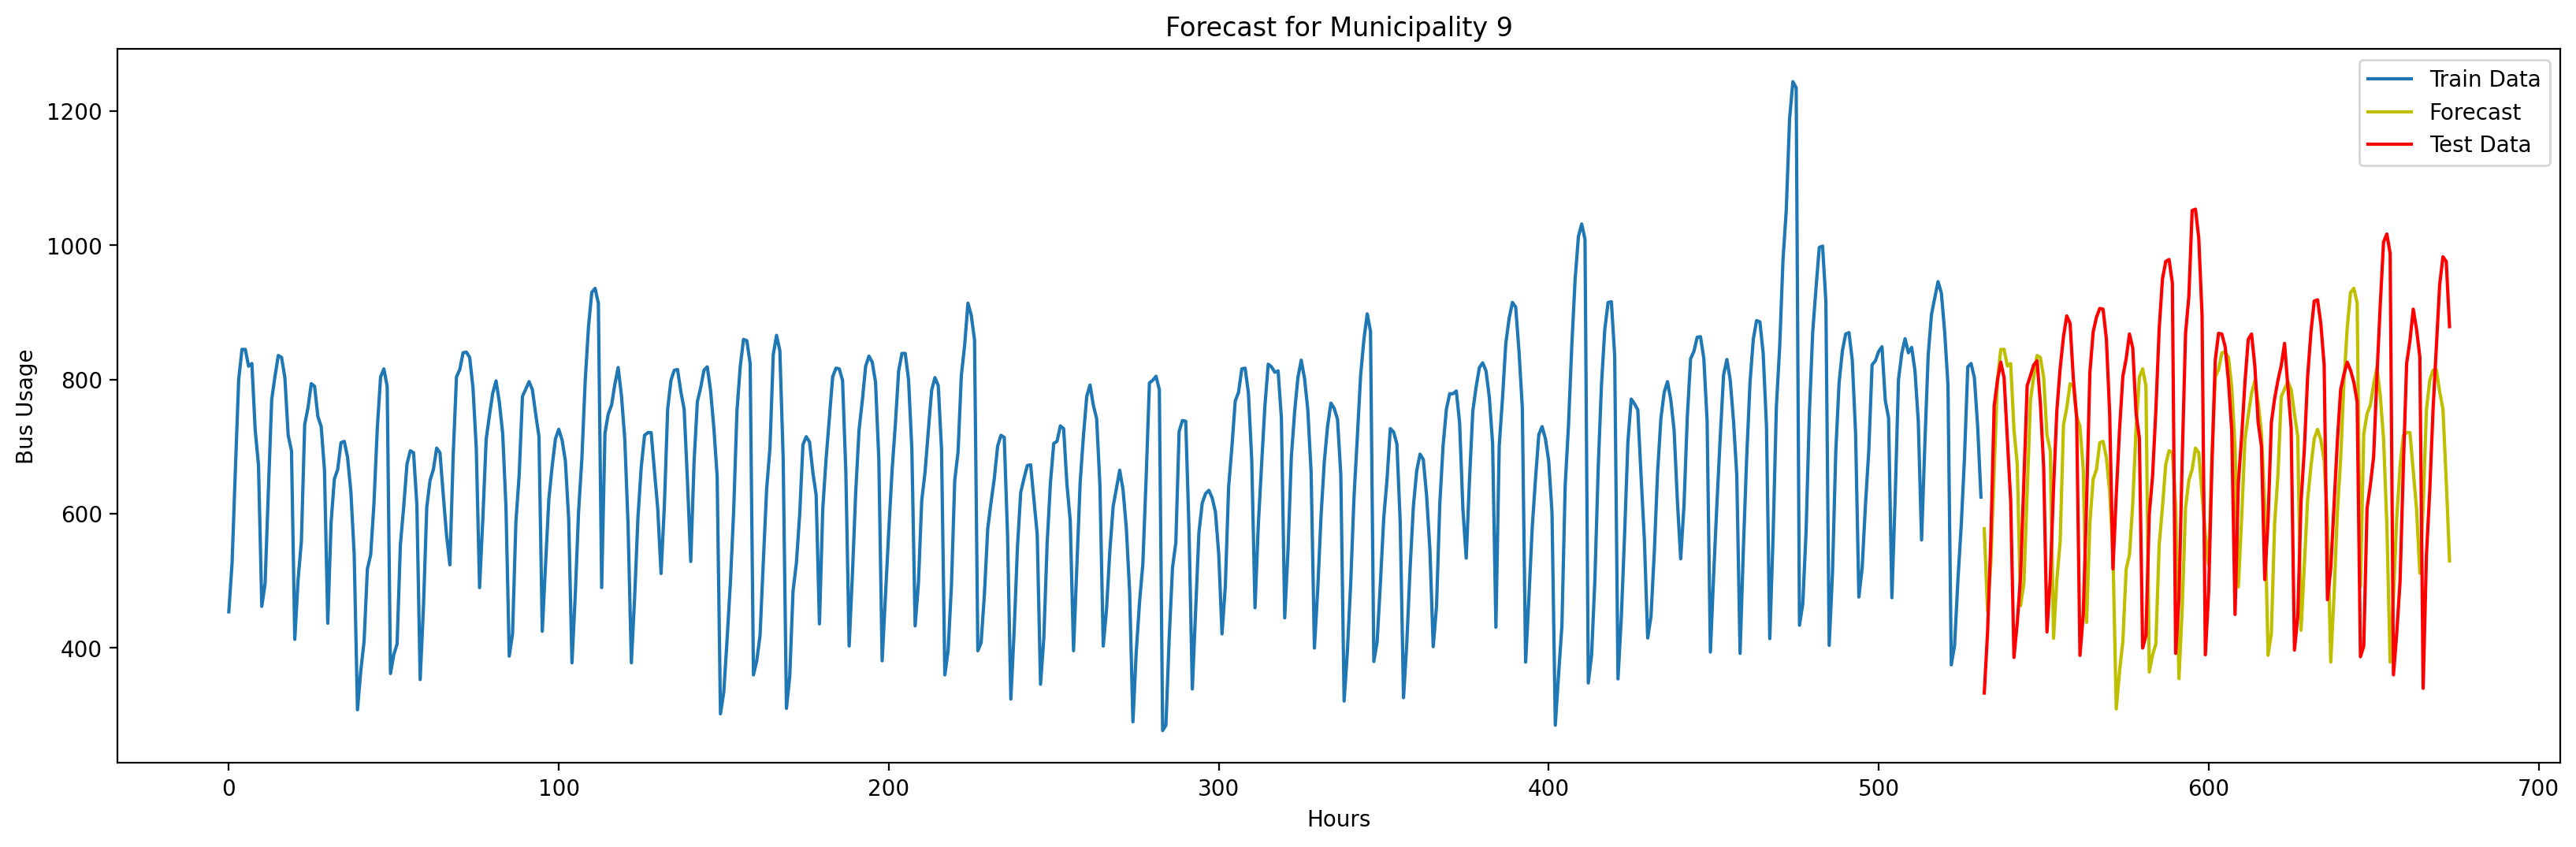

In [449]:
prediction_holder = {}
loss_holder = {}
for i in range(10):
    model = ExponentialSmoothing(traindata_holder['traindata' + str(i)]["usage"])
    model = ExponentialSmoothing.fit(model, remove_bias=True, optimized=True)

    if i == 0:
        print(model.summary())
    prediction_holder['prediction' + str(i)] = HoltWintersResults.predict(model, start=testdata_holder['testdata' + str(i)]["usage"].index[0], end=testdata_holder['testdata' + str(i)]["usage"].index[-1])
    prediction_holder['prediction' + str(i)] = pd.Series(prediction_holder['prediction' + str(i)])
    prediction_holder['prediction' + str(i)].index += len(traindata_holder['traindata' + str(i)])
    testdata_holder['testdata' + str(i)].index += len(traindata_holder['traindata' + str(i)])
    plt.figure(figsize=(20, 6), dpi=200)
    plt.plot(traindata_holder['traindata' + str(i)]["usage"].index, traindata_holder['traindata' + str(i)]["usage"], label='Train Data')
    plt.plot(prediction_holder['prediction' + str(i)].index, prediction_holder['prediction' + str(i)], 'y-', label = 'Forecast')
    plt.plot(testdata_holder['testdata' + str(i)]["usage"].index, testdata_holder['testdata' + str(i)]["usage"], 'r-', label = 'Test Data')
    plt.xlabel('Hours'); plt.ylabel('Bus Usage'); plt.title('Forecast for Municipality %d' %i)
    plt.legend(loc="best")
